# FWI modelo personalizado

In [1]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, ImageFiltering, DelimitedFiles, Dates

┌ Info: Initializing openacc/openmp offloading
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/JUDI.jl:123


In [2]:
M = load("model_custom.jld");

In [3]:
#model = Model(M["n"], M["d"], M["o"], M["m"])
model0 = Model(M["n"], M["d"], M["o"], M["m0"])
dm = vec(M["dm"]);

In [4]:
vmin = ones(Float32,model0.n) .* 1.5f0
vmax = ones(Float32,model0.n) .* 3.0f0;
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2);

In [5]:
block = segy_read("model_custom_low_f.segy")
d_obs = judiVector(block);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=4763124, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geopc3/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


In [6]:
# Set up wavelet
srcGeometry = Geometry(block; key="source")	# read source position geometry
wavelet = ricker_wavelet(srcGeometry.t[1], srcGeometry.dt[1], 0.004f0)	# 4 Hz wavelet
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 21 sources


In [7]:
F0 = judiModeling(deepcopy(model0), srcGeometry, d_obs.geometry)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)


In [8]:
# Optimization parameters
niterations = parse(Int, get(ENV, "NITER", "30"))
batchsize = 16
fhistory_SGD = zeros(Float32, niterations);
m0_values = zeros(length(model0.m), niterations);

In [9]:
# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)
ls = BackTracking(order=3, iterations=10, );

In [10]:
# Main loop
t1 = now();
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    p = -gradient/norm(gradient, Inf)
    
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    function ϕ(α)
        F0.model.m .= proj(model0.m .+ α * p)
        misfit = .5*norm(F0[i]*q[i] - d_obs[i])^2
        @show α, misfit
        return misfit
    end
    step, fval = ls(ϕ, 1f-1, fval, dot(gradient, p))

    # Update model and bound projection
    model0.m .= proj(model0.m .+ step .* p)
    m0_values[:, j] = model0.m
end
t2 = now();

Building forward operator
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] a

FWI iteration no: 1; function value: 61812.78
(α, misfit) = 

(0.1f0, 115857.5703125)


Building forward operator
Operator `forward` ran in 0.34 s
Operator `forward` ran in 0.26 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.0394236738005976, 24691.15234375)
FWI iteration no: 

Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s


2; function value: 24647.87


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 7309.59521484375)
FWI iteration no: 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s


3; function value: 7707.1284


Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.109386625e6)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s


(0.010000000149011612, 11131.4873046875)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s


(α, misfit) = (0.0036747631984997762, 5388.49462890625)
FWI iteration no: 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s


4; function value: 5182.0654


Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 28050.759765625)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s


(0.033325704028712884, 2835.363525390625)


Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


FWI iteration no: 5; function value: 3589.7356
(α, misfit) = 

Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.

(0.1f0, 93081.2734375)


Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.014497071266947882, 1883.1871337890625)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


6; function value: 1967.4882


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 61434.64453125)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.018861621190020886, 2871.645751953125)


Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.007943209438929953, 1513.1937255859375)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


7; function value: 1462.1814


Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.11939975e6)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s


(0.010000000149011612, 11020.06640625)


Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s


(α, misfit) = (0.0012035525196871903, 1081.508544921875)
FWI iteration no: 

Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


8; function value: 1236.5719


Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 18210.19140625)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(0.019958074530786477, 1432.517578125)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.008777560533561242, 957.5785522460938)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


9; function value: 994.30896


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 536784.0625)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s


(0.010000000149011612, 4720.970703125)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.23 s


(α, misfit) = (0.001552294718388733, 777.0029907226562)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


10; function value: 1012.83075


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 125912.8203125)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s


(0.010000000149011612, 1831.54345703125)


Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.0029669423252926736, 909.1900024414062)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


11; function value: 977.64465


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.103753875e6)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s


(0.010000000149011612, 11157.015625)


Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s


(α, misfit) = (0.0010000000149011613, 738.3942260742188)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


12; function value: 888.1012


Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 14020.384765625)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s


(0.019703178433674483, 1002.9224243164062)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.008845217886314233, 708.6652221679688)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


13; function value: 802.4564


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.131811125e6)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


(0.010000000149011612, 10313.53515625)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.0010000000149011613, 598.8225708007812)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


14; function value: 721.0831


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 131738.0)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(0.010000000149011612, 1664.5101318359375)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


(α, misfit) = (0.0024199489580994313, 614.7321166992188)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


15; function value: 634.37274


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.066201625e6)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s


(0.010000000149011612, 10322.298828125)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.0010000000149011613, 480.86981201171875)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


16; function value: 602.44214


Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 2601.392578125)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(0.039486944444936646, 673.1114501953125)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.01730416195087907, 470.92138671875)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


17; function value: 606.19977


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.116978625e6)
(α, misfit) = 

Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(0.010000000149011612, 10327.197265625)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.0010000000149011613, 403.6026916503906)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s


18; function value: 492.7274


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 107062.484375)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(0.010000000149011612, 1250.751953125)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.002646988595367802, 397.8712463378906)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


19; function value: 461.11298


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 964887.875)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s


(0.010000000149011612, 9375.28515625)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.0010000000149011613, 315.658447265625)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


20; function value: 463.18686


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.23 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 28947.771484375)
(α, misfit) = 

Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s


(0.011649173652902363, 645.2689208984375)


Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.004793905537667189, 379.54095458984375)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s


21; function value: 455.81308


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.158631875e6)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s


(0.010000000149011612, 10398.4365234375)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.0010000000149011613, 307.3298034667969)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s


22; function value: 427.4283


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 59270.609375)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(0.010000000149011612, 791.5580444335938)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.003378254225019044, 355.29913330078125)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


23; function value: 500.0255


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.0708995e6)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s


(0.010000000149011612, 11023.716796875)


Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.0010000000149011613, 312.7325134277344)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


24; function value: 426.44937


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 13165.6630859375)
(α, misfit) = 

Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(0.019791081116840328, 709.3795776367188)


Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.008003144978656476, 349.009765625)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


25; function value: 445.93744


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.23 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.077624125e6)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s


(0.010000000149011612, 9711.71875)


Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.0010000000149011613, 284.2490539550781)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


26; function value: 405.53085


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 119367.3515625)
(α, misfit) = 

Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s


(0.010000000149011612, 1337.110595703125)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.002528417527995216, 324.012451171875)
FWI iteration no: 

Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


27; function value: 395.69315


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.12988925e6)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(0.010000000149011612, 11212.318359375)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


(α, misfit) = (0.0010000000149011613, 252.77784729003906)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


28; function value: 362.29333


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 5266.4853515625)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


(0.031762801423087635, 708.9412841796875)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


(α, misfit) = (0.012768627968781709, 314.84765625)
FWI iteration no: 

Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


29; function value: 446.1439


Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.099585e6)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


(0.010000000149011612, 10266.36328125)


Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s


(α, misfit) = (0.0010000000149011613, 265.40142822265625)
FWI iteration no: 

Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


30; function value: 367.34033


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.23 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 76868.5)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s


(0.010000000149011612, 862.4722900390625)


Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


(α, misfit) = (0.003059831101555763, 279.49822998046875)


Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s


In [11]:
fwi = sqrt.(1f0./adjoint(reshape(m0_values[:, 29], (101,101))));
v0 = sqrt.(1f0./M["m0"])';
v = sqrt.(1f0./M["m"])';

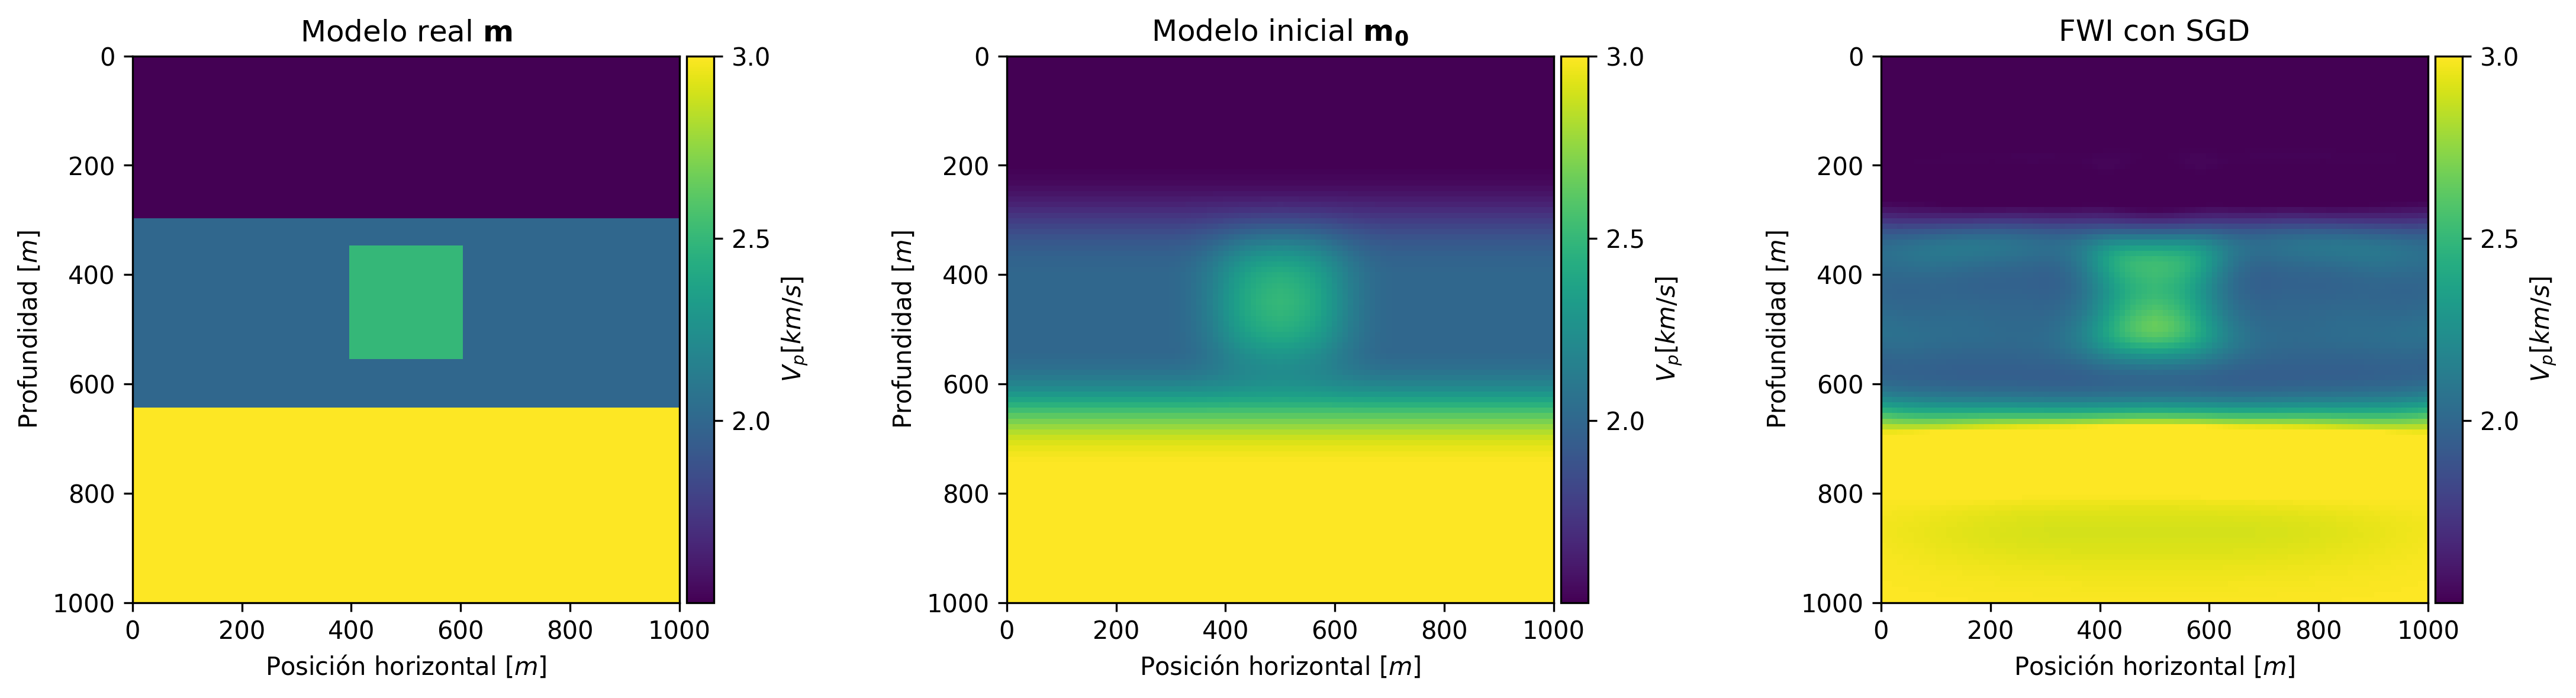

In [12]:
fig=figure(figsize=(18,4), dpi=300);
subplot(131)
im = imshow(v, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo real $\mathbf{m}$")
subplot(132)
im = imshow(v0, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo inicial $\mathbf{m_0}$")
subplot(133)
im = imshow(fwi, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI con SGD")
display(fig)

In [13]:
mse = sum((v .- v0).^2) / length(v)
println("El error cuadrático medio del modelo inicial es: ", mse)
mse = sum((v .- fwi).^2) / length(v)
println("El error cuadrático medio de FWI es: ", mse)

El error cuadrático medio del modelo inicial es: 0.01610154849900713
El error cuadrático medio de FWI es: 0.010837943355116458


In [14]:
error_porcentaje_v0 = 100 * sum(abs.(v - v0)) / sum(abs.(v))
error_porcentaje_fwi = 100 * sum(abs.(v - fwi)) / sum(abs.(v))

println("Porcentaje de error (v0): ", error_porcentaje_v0)
println("Porcentaje de error (FWI): ", error_porcentaje_fwi)

Porcentaje de error (v0): 2.9251756195527445
Porcentaje de error (FWI): 2.193945655376541


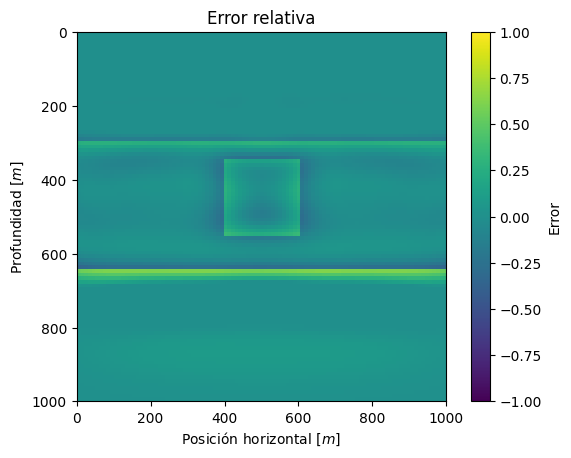

In [15]:
difs = v-fwi
fig=figure() #figsize=(20, 5)
im = imshow(difs, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=-1, vmax=1)
cb = colorbar(im)
cb[:set_label](label = "Error")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Error relativa")
display(fig)

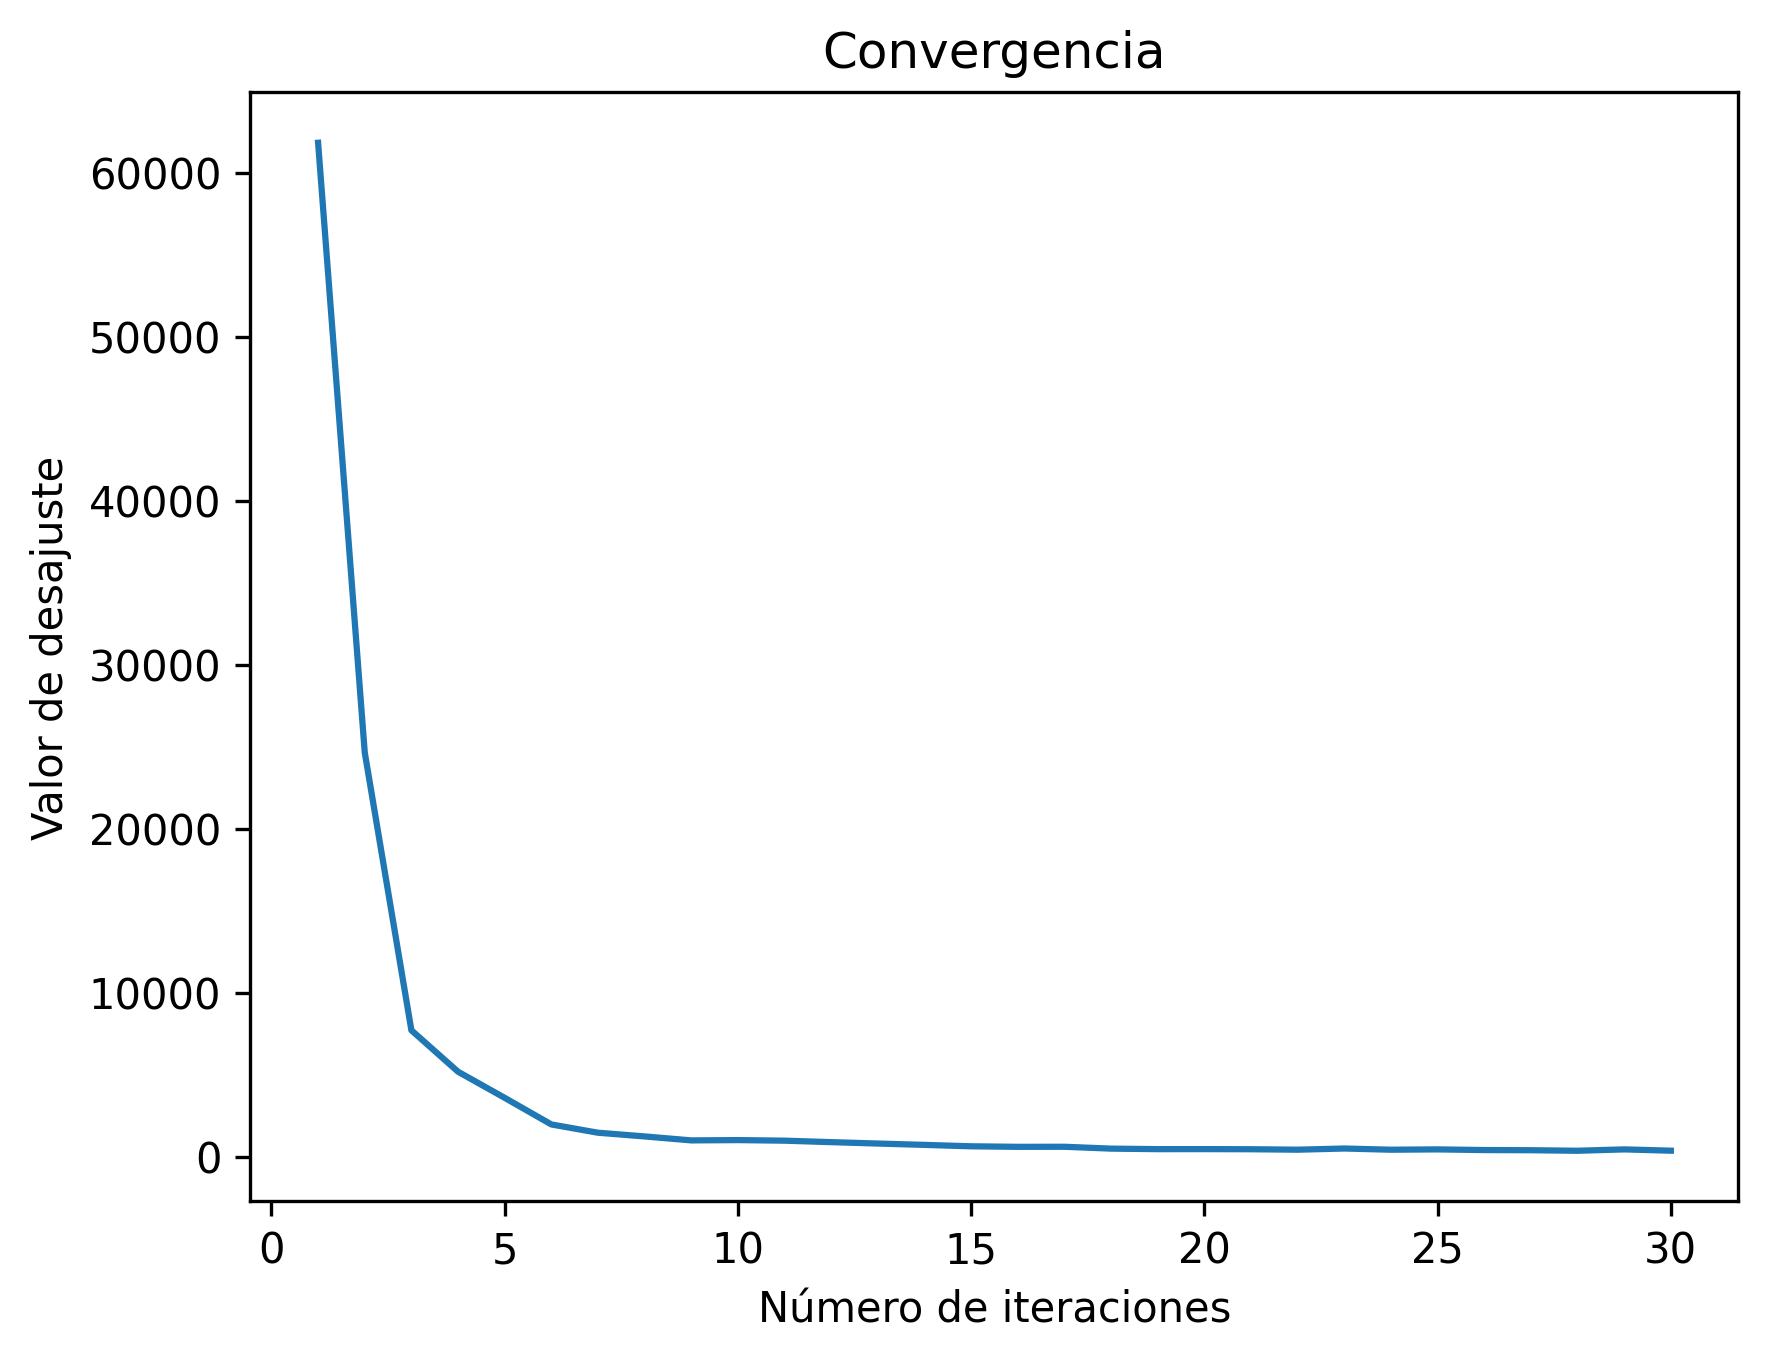

In [16]:
fig=figure(dpi=300) #figsize=(20, 5)
xax = 1:1:30
plot(xax, fhistory_SGD)
xlabel("Número de iteraciones")
ylabel("Valor de desajuste")
title("Convergencia")
display(fig)

In [17]:
save("model_custom_fwi_result_low_f.jld", "n", M["n"], "d", M["d"], "o", M["o"], "m", M["m"], "m0", model0.m.data, "dm", dm)

In [18]:
writedlm("fwi_l_results/m0.txt", v0)
writedlm("fwi_l_results/fwi.txt", m0_values)
writedlm("fwi_l_results/mtrue.txt", v)
writedlm("fwi_l_results/fval.txt", fhistory_SGD)

In [19]:
canonicalize(t2 - t1)

8 minutes, 10 seconds, 34 milliseconds

In [20]:
t2-t1

490034 milliseconds